# Import and Clean Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectKBest, chi2


Load Data and Cleaning

In [2]:
df = pd.read_csv(r"C:\Users\User\Desktop\python data science\ChurnEmployent\telco.csv")

In [3]:
print( df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.shape

(7043, 21)

In [6]:
df.isna().sum()*100

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
# Target distribution
print(df["Churn"].value_counts())
print(df["Churn"].value_counts(normalize=True))

Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


# Fix Missing / Blank Values

In [8]:
# Convert blanks -> NAN then to numeric value
df['TotalCharges'] = pd.to_numeric(
    df['TotalCharges'].astype(str).str.strip().replace("",np.nan),
    errors = 'coerce'
)

    #Confirm missing values
print(df.isna().sum().sort_values(ascending=False).head(10))


TotalCharges      11
gender             0
SeniorCitizen      0
Partner            0
customerID         0
Dependents         0
tenure             0
MultipleLines      0
PhoneService       0
OnlineSecurity     0
dtype: int64


In this dataset, TotalCharges is stored as text and can contain blanks; convert it to numeric and turn blanks into NaN so imputers can handle them. 

# : Exploratory Data Analysis (EDA)

In [9]:
# =========================
# Telco Churn - EDA (Full)
# =========================


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
df["ChurnFlag"] = (df["Churn"] == "Yes").astype(int)



Overall churn rate: 26.54%


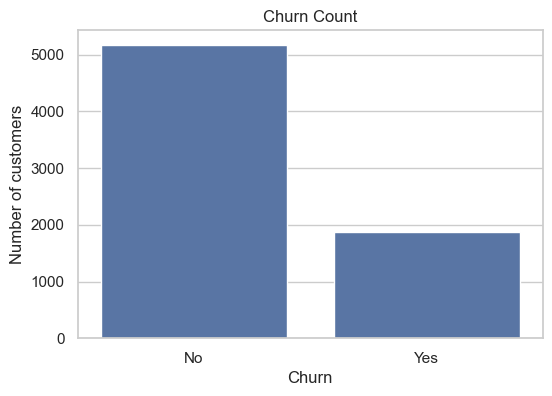

In [10]:
# ---------------------------------------------------------
# A) Overall churn rate (calculation + visualization)
# ---------------------------------------------------------



churn_rate = df["ChurnFlag"].mean()
print(f"\nOverall churn rate: {churn_rate:.2%}")


plt.figure(figsize=(6,4))
sns.barplot(x=["No", "Yes"], y=df["Churn"].value_counts().reindex(["No","Yes"]).values)
plt.title("Churn Count")
plt.xlabel("Churn")
plt.ylabel("Number of customers")
plt.show()





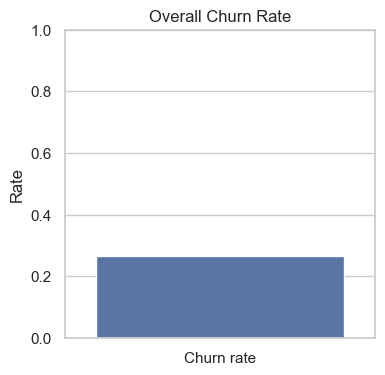

In [11]:
plt.figure(figsize=(4,4))
sns.barplot(x=["Churn rate"], y=[churn_rate])
plt.ylim(0, 1)
plt.title("Overall Churn Rate")
plt.ylabel("Rate")
plt.show()

In [12]:
def churn_rate_by_category(data, col):
    return (data.groupby(col)["ChurnFlag"].mean() * 100).round(2).sort_values(ascending=False)

print(churn_rate_by_category(df, "Contract"))
print(churn_rate_by_category(df, "PaymentMethod"))

Contract
Month-to-month    42.71
One year          11.27
Two year           2.83
Name: ChurnFlag, dtype: float64
PaymentMethod
Electronic check             45.29
Mailed check                 19.11
Bank transfer (automatic)    16.71
Credit card (automatic)      15.24
Name: ChurnFlag, dtype: float64


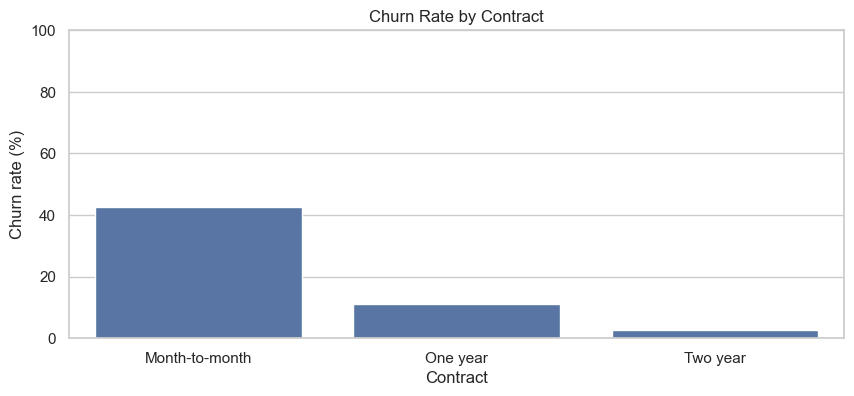

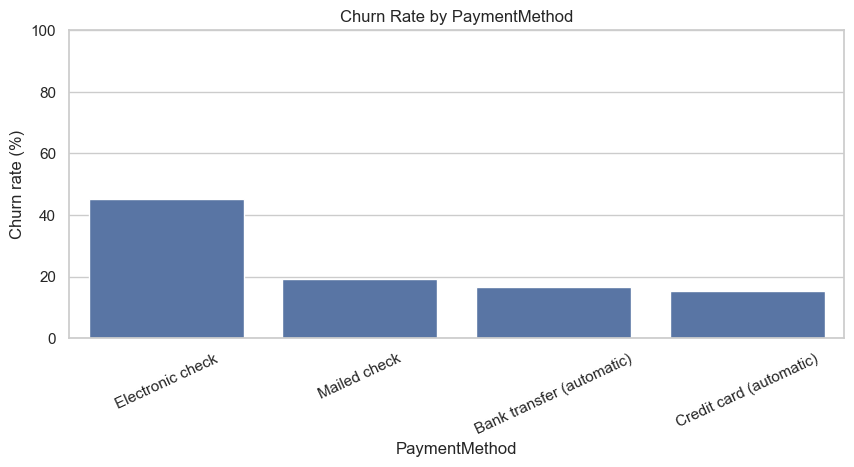

In [13]:
def barplot_churn_rate(data, col, order=None, rotate=0):
    # churn rate (%) per category
    tmp = (data.groupby(col, dropna=False)["ChurnFlag"].mean() * 100).sort_values(ascending=False)

    if order is not None:
        tmp = tmp.reindex(order)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=tmp.index.astype(str), y=tmp.values)
    plt.title(f"Churn Rate by {col}")
    plt.xlabel(col)
    plt.ylabel("Churn rate (%)")
    plt.xticks(rotation=rotate)
    plt.ylim(0, 100)
    plt.show()

# Example 1: Contract
barplot_churn_rate(df, "Contract", order=["Month-to-month", "One year", "Two year"])

# Example 2: PaymentMethod
barplot_churn_rate(df, "PaymentMethod", rotate=25)

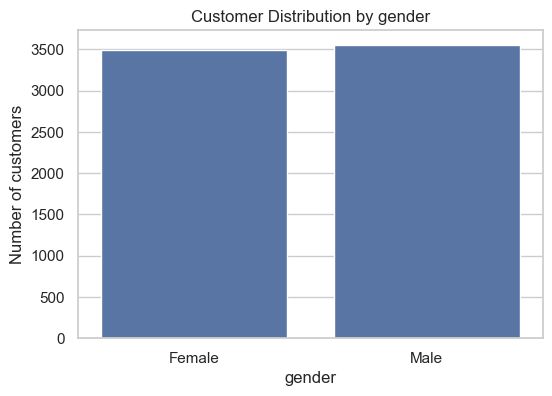

NameError: name 'plot_churn_rate_by_category' is not defined

In [14]:
# ---------------------------------------------------------
# B) Customer distribution by Gender / Partner / Dependents
#    + churn rate by each group
# ---------------------------------------------------------
for col in ["gender", "Partner", "Dependents"]:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, order=sorted(df[col].dropna().unique()))
    plt.title(f"Customer Distribution by {col}")
    plt.xlabel(col)
    plt.ylabel("Number of customers")
    plt.show()

    plot_churn_rate_by_category(df, col)

In [ ]:
# ---------------------------------------------------------
# C) Tenure distribution and relationship with churn
# ---------------------------------------------------------
# Tenure distribution overall
plt.figure(figsize=(10,4))
sns.histplot(data=df, x="tenure", bins=30, kde=True)
plt.title("Tenure Distribution")
plt.xlabel("Tenure (months)")
plt.ylabel("Customers")
plt.show()

# Tenure distribution split by churn
plt.figure(figsize=(10,4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, kde=True, element="step")
plt.title("Tenure Distribution by Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Customers")
plt.show()

# Churn rate by tenure "bins" (easier to interpret)
tenure_bins = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 36, 48, 60, 72],
    include_lowest=True,
    right=True
)
df["tenure_group"] = tenure_bins.astype(str)

plot_churn_rate_by_category(df, "tenure_group", rotate=30)


In [ ]:
# ---------------------------------------------------------
# D) Churn vs Contract type
# ---------------------------------------------------------
# Typical order for contract types
contract_order = ["Month-to-month", "One year", "Two year"]
plot_churn_rate_by_category(df, "Contract", order=contract_order, rotate=0)

plt.figure(figsize=(8,4))
sns.countplot(data=df, x="Contract", hue="Churn", order=contract_order)
plt.title("Contract Type vs Churn (Counts)")
plt.xlabel("Contract")
plt.ylabel("Customers")
plt.show()



In [ ]:
# ---------------------------------------------------------
# E) Churn vs Payment method
# ---------------------------------------------------------
# Churn rate by payment method
plot_churn_rate_by_category(df, "PaymentMethod", rotate=25)

plt.figure(figsize=(10,4))
sns.countplot(data=df, x="PaymentMethod", hue="Churn")
plt.title("Payment Method vs Churn (Counts)")
plt.xlabel("PaymentMethod")
plt.ylabel("Customers")
plt.xticks(rotation=25)
plt.show()

# Data cleaning (why it matters)
TotalCharges is converted from text to numeric, and blanks are turned into missing values (NaN).

This step is necessary because otherwise plots/statistics involving TotalCharges can be incorrect or fail (for example, “numbers” treated as strings).

ChurnFlag converts Churn from "Yes"/"No" into 1/0, which makes churn rate calculations simple: the mean of ChurnFlag equals the churn rate.

# Overall churn rate plot
churn_rate = df["ChurnFlag"].mean() computes the overall churn rate (percentage of customers who churned).

The churn count bar chart shows whether the dataset is imbalanced (usually more “No” than “Yes”), which affects model evaluation (accuracy alone can be misleading).

The churn-rate bar (0–1 scale) is a quick “baseline” that later group churn rates can be compared against.

## Gender / Partner / Dependents (distribution + churn rate)
The count plots show how many customers exist in each group (example: Male vs Female), which helps detect if some categories are rare.

The churn-rate-by-category bars show risk differences: a higher bar means that group churns more often.

If churn rates are similar across gender, gender is likely a weak predictor; if churn is clearly higher for customers without partner/dependents, those fields can be meaningful predictors (often reflecting household stability).

## Tenure distribution and churn relationship
The overall tenure histogram shows whether many customers are new (low tenure) or long-term (high tenure).

The histogram split by Churn helps answer: “Do churners cluster at low tenure?”—commonly, churn is higher among new customers and decreases as tenure increases.

The tenure_group churn-rate plot is the easiest to interpret for business use: if the 0–12 month bin has the highest churn rate, early retention interventions should be prioritized.

# Contract type vs churn
The churn-rate plot by Contract typically shows Month-to-month with the highest churn and longer contracts with lower churn, because longer commitments reduce switching.

The count plot with hue (Churn) shows both volume and churn concentration: a category can have high churn rate but low customer count, or vice versa.

If contract type strongly separates churn rates, it will usually become one of the most important features in modeling.

# Payment method vs churn
The churn-rate-by-PaymentMethod plot identifies whether certain payment types correlate with churn risk (often reflecting customer segment and payment friction).

The count plot shows whether the high-risk payment method is common enough to matter operationally (high risk + high volume is a priority).

If one payment method stands out with a much higher churn rate, it suggests targeted actions (billing UX improvements, incentives to switch payment type, etc.).

# Full conclusion (what this EDA supports)
The EDA establishes a churn baseline and then checks which customer attributes show visible churn separation; variables showing large churn-rate differences (commonly tenure groups, contract type, and sometimes payment method) are strong candidates for predictive modeling and for business interventions.

Tenure-based churn patterns (often high churn early, lower churn later) suggest retention work should focus on onboarding and the first-year experience, while contract/payment patterns suggest commercial levers (contract offerings, discounts, payment experience) can reduce churn.

For the next step (modeling), these plots justify using stratified train/test splits, considering imbalance-aware metrics (AUC, F1), and including the high-signal categorical features via one-hot encoding as done earlier.

In [ ]:
# -------------------------
# 2) Create segments
# -------------------------

# (A) Tenure segments (months)
tenure_bins = [0, 12, 24, 36, 48, 60, 72]
tenure_labels = ["0-12", "13-24", "25-36", "37-48", "49-60", "61-72"]
df["TenureSegment"] = pd.cut(df["tenure"], bins=tenure_bins, labels=tenure_labels, include_lowest=True)

# (B) MonthlyCharges segments (quartiles: Low -> High)
df["ChargesSegment"] = pd.qcut(
    df["MonthlyCharges"], q=4,
    labels=["Low", "Mid-Low", "Mid-High", "High"]
)

# (C) Contract is already a category in the dataset
# df["Contract"] is used directly


# -------------------------
# 3) Churn rate within segments
# -------------------------
segment_summary = (
    df.groupby(["TenureSegment", "ChargesSegment", "Contract"], dropna=False)
      .agg(
          customers=("customerID", "count"),
          churn_rate=("ChurnFlag", "mean"),
          avg_monthly=("MonthlyCharges", "mean")
      )
      .reset_index()
)

segment_summary["churn_rate_pct"] = (segment_summary["churn_rate"] * 100).round(2)
segment_summary["avg_monthly"] = segment_summary["avg_monthly"].round(2)

# Show the biggest segments (by customer count)
print("\nTop segments by customer count:")
print(segment_summary.sort_values("customers", ascending=False).head(15))
overall_churn_rate = df["ChurnFlag"].mean()
print("Overall churn rate:", overall_churn_rate)
print("Overall churn rate (%):", round(overall_churn_rate * 100, 2), "%")
# -------------------------
# 4) Identify high-value customers at risk
# -------------------------
# Simple business rule (easy to explain in report):
# High-value = ChargesSegment == "High"
# At-risk = Contract == "Month-to-month" AND churn_rate > overall churn rate
high_value_at_risk_segments = (
    segment_summary[
        (segment_summary["ChargesSegment"] == "High") &
        (segment_summary["Contract"] == "Month-to-month") &
        (segment_summary["churn_rate"] > overall_churn_rate)
    ]
    .sort_values("churn_rate", ascending=False)
)

print("\nHigh-value at-risk segments (High charges + Month-to-month + above-average churn):")
print(high_value_at_risk_segments)


# -------------------------
# 5) (Optional) List the actual customers in those risky segments
# -------------------------
# Pick one segment to pull customer rows (example: high charges + 0-12 months + month-to-month)
target_tenure_segment = "0-12"

at_risk_customers = df[
    (df["ChargesSegment"] == "High") &
    (df["TenureSegment"].astype(str) == target_tenure_segment) &
    (df["Contract"] == "Month-to-month")
].copy()

# Sort to see the most expensive customers first
at_risk_customers = at_risk_customers.sort_values("MonthlyCharges", ascending=False)

print(f"\nSample high-value customers in at-risk segment (TenureSegment={target_tenure_segment}):")
print(at_risk_customers[["customerID", "tenure", "MonthlyCharges", "Contract", "Churn"]].head(20))

Segmentation: creates customer groups using TenureSegment (time with company), ChargesSegment (spending level), and Contract (commitment level).
Churn rate within segments: for each segment, it calculates churn_rate = mean(ChurnFlag) and prints it as a percentage.
High-value at-risk: flags segments where customers pay high monthly charges and are month‑to‑month (usually easier to leave) and where churn is higher than the overall churn baseline. 

# Train and Evaluate Machine Learning at least three Models

In [ ]:
# ---------------------------
# 1) Define X and y
# ---------------------------
y = df["Churn"].map({"No": 0, "Yes": 1}).astype(int)
X = df.drop(columns=["Churn", "customerID"])   # customerID is just an identifier

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing for most models
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

# Split dataset (stratify keeps churn ratio similar)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# ---------------------------
# 2) Train 4 models + compare
# ---------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
    "LinearSVC": LinearSVC(class_weight="balanced", random_state=42)
}

def evaluate(pipe, name):
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0)
    }

results = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    results.append(evaluate(pipe, name))

results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
print("\n=== Baseline Model Comparison (sorted by F1) ===")
print(results_df)



In [15]:
# ---------------------------
# 4) Feature selection + hyperparameter tuning (example: Logistic Regression)
#    Use chi2 => needs non-negative features, so use MinMaxScaler instead of StandardScaler
# ---------------------------
preprocess_chi2 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("minmax", MinMaxScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

pipe_lr_fs = Pipeline([
    ("prep", preprocess_chi2),
    ("select", SelectKBest(score_func=chi2, k=25)),
    ("model", LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear"))
])

param_grid = {
    "select__k": [15, 25, 35],
    "model__C": [0.1, 1.0, 3.0, 10.0]
}

gs = GridSearchCV(pipe_lr_fs, param_grid, scoring="f1", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_
best_pred = best_model.predict(X_test)

print("\n=== Best Tuned LR + Feature Selection ===")
print("Best params:", gs.best_params_)
print({
    "Accuracy": accuracy_score(y_test, best_pred),
    "Precision": precision_score(y_test, best_pred, zero_division=0),
    "Recall": recall_score(y_test, best_pred, zero_division=0),
    "F1": f1_score(y_test, best_pred, zero_division=0)
})

NameError: name 'num_cols' is not defined